# Entrega 1 - Predictor de muerte de pacientes con HIV

### Grupo 26:
     - Agustín Martínez  C.I 5.074.743-0
     - Joaquín Mezquita  C.I 5.239.865-9
     - Nicolás Núñez     C.I 5.127.722-0
     



## 1. Objetivo

El objetivo de esta tarea es construir un algortimo capaz de predecir la muerte de pacientes bajo observación por HIV utilizando árboles de decisión generados con el algoritmo ID3 visto en el curso. Para ello, utilizaremos el dataset `AIDS Clinical Trials Group Study 175` tomando como valor a predecir el indicador de censura `cid`. 

El indicador de censura puede tomar dos valores "censoring" o "failure". La censura ocurre cuando un valor de una observación solo se conoce parcialmente. 

En este caso ocurre cuando el experimento termina en un momento determinado, tras el cuál los pacientes todavía vivos quedan todos censurados por la derecha.  

Luego del momento de la última observación no se conocen datos sobre la muerte o supervivencia de los pacientes. Por lo que se puede tomar únicamente el caso "failure" como la muerte de un paciente.d


El éxito del aprendizaje se medirá a traves de las métricas accuracy, precisión, recall y f1, dandole más importancia a la primera y última (podemos tirar algo mas de texto aca)


In [1]:
import funciones
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Objetivo a predecir
OBJETIVO = 'cid'

dataset = pd.read_csv('data.csv')

## Entrenamiento del predictor

Para evaluar la precisión del modelo, el dataset es separado en 3 conjuntos:

- Entrenamiento (70%): Utilizado para entrenar el árbol con el algoritmo ID3
- Validación (15%): Para ajustar los valores de los hiperparametros
- Evaluación (15%): Para probar la precisión del modelo una vez finalizado.

Además, a la hora de separarlos, utilizamos el parametro `stratify=True` de forma que la distribución de la columna `cid` sea similar en los 3 subconjuntos

In [2]:
X = dataset.copy().drop(columns=[OBJETIVO])
Y = dataset[OBJETIVO].copy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 12345, stratify=Y)
X_train, X_validacion, Y_train, Y_validacion = train_test_split(X_train, Y_train, test_size=0.15, random_state=12345, stratify=Y_train)

X_librerias = dataset.copy().drop(columns=[OBJETIVO])
Y_librerias = dataset[OBJETIVO].copy()

X_train_librerias, X_test_librerias, Y_train_librerias, Y_test_librerias = train_test_split(X_librerias, Y_librerias, test_size = 0.15, random_state = 12345, stratify=Y_librerias)

## Linea base y linea máxima

Podemos trazar como linea base de nuestro predictor un modelo sencillo el cual siempre predice que el resultado será la clase más probable, y como linea máxima, la implementación de random forest utilizada más adelante.

In [3]:
dataset.cid.value_counts()

cid
0    1618
1     521
Name: count, dtype: int64

Vemos que el dataset cuenta con 1618 entradas cuyo resultado es 0 (lo que implica que el paciente no murió durante la observación), y 521 cuyo resultado es 1. 
Tomando esto en cuenta, el predictor simple mencionado anteriormente devolverá que el resultado es siempre 0.
A continuación se muestran los resultados de un modelo con esta característica.

In [5]:
Y_predicho = [0 for _ in range(len(dataset))]
Y_real = dataset[OBJETIVO]

accuracy, precision, recall, f1 = funciones.get_accuracy_precision_recall_f1(Y_real, Y_predicho, objetivo=0)

print('Accuracy de linea base:', accuracy)
print('Precision de linea base:', precision)
print('Recall de linea base:', recall)
print('F1 de linea base:', f1)

Accuracy de linea base: 0.7564282374941561
Precision de linea base: 0.7564282374941561
Recall de linea base: 1.0
F1 de linea base: 0.8613255256853872


Como era de esperar, el accuracy y precisión son equivalentes a la proporción de entradas cuyo resultado es 0 en el dataset.

Por otro lado, y adelantandonos ligeramente sobre los resultados, podemos calcular las mismas métricas sobre la implementación de random forest de la librería scikit-learn, sobre la que entraremos en detalle más adelante.

In [5]:
RandomForest = RandomForestClassifier(criterion='entropy', random_state=12345)
RandomForest.fit(X_train_librerias, Y_train_librerias)
Y_predicho_random_forest = RandomForest.predict(X_test_librerias)

accuracy, precision, recall, f1 = funciones.get_accuracy_precision_recall_f1(Y_test_librerias, Y_predicho_random_forest, objetivo=0)

print('Accuracy de linea máxima:', accuracy)
print('Precision de linea máxima:', precision)
print('Recall de linea máxima:', recall)
print('F1 de linea máxima:', f1)

Accuracy de linea máxima: 0.8909657320872274
Precision de linea máxima: 0.9126984126984127
Recall de linea máxima: 0.9465020576131687
F1 de linea máxima: 0.9292929292929293


Con estas métricas, se espera que el predictor implementado obtenga resultados intermedios entre ambas lineas trazadas.

## 2. Diseño del predictor

## Discretización del dataset

Antes de entrenar el árbol, se discretizan las variables que tomen valores numéricos continuos, o valores discretos dentro de un intervalo amplio. Es decir, para cada atributo a discretizar, se generan rangos, y cada valor es reemplazado por el índice del rango en el que se encuentra, reduciendo así la cantidad de valores distintos que puede tomar cada atributo.

Para esto, se buscan los mejores puntos de corte que maximicen la ganancia de información. Primero, se calculan todos los posibles puntos de corte para un atributo y se evalúa cual es su ganancia. Luego, se seleccionan los puntos que generan la mejor ganancia de información, respetando el valor de max_range_split. Finalmente, los valores originales del atributo se reemplazan por el índice del rango al que pertenecen, simplificando así el modelo.

Tomando en cuenta las observaciones hechas a las columnas y los valores del dataset, los atributos a discretizar son: 

- pidnum
- time
- age
- wtkg
- karnof
- preanti
- cd40
- cd420
- cd80
- cd820

In [6]:
atributos_a_discretizar = ['pidnum', 'time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']

## Funciones de selección de atributos

Para evaluar el mejor atributo a seleccionar en cada paso recursivo, se implementan las funciones ''Ganancia'', siendo esta la función básica que busca reducir la incertidumbre al elegir un atributo, ''Gain Ratio'', el cual ajusta la ganancia de información para evitar el sesgo hacia atributos con muchos valores posible, y por último ''Impurity Reduction'', el cual mide que tan ''puro'' es un conjunto de datos (un conjunto es más ''puro'' en caso de contener menos cantidad de valores distintos)

## Preprocesamiento de datos

Por un lado, dado que el conjunto de datos no contiene atributos con elementos faltantes, no es necesario hacer nada al respecto. Por otro lado, los atributos cateogricos `trt` y `strat` utilizan más de 2 categorias en un solo atributo, por lo que estas dos columnas impondrán un orden donde no lo hay, empeorando así el rendimiento de las implementaciones de la libreria `scikit-learn`, por lo que se aplicará `one-hot encoding` sobre los dos atributos mencionados esperando una mejora en los resultados.
Por último, se experimentará también con categorizar las variables anteriormente dichas antes o durante la ejecución del algoritmo ID3.

In [7]:
atributos_a_aplicar_one_hot_encoding = ['trt', 'strat']


## Evaluación
- Qué conjunto de métricas se utilizan para la evaluación de la solución y su definición
- Sobre qué conjunto(s) se realiza el entrenamiento, ajuste de la solución, evaluación, etc. Explicar cómo se construyen estos conjuntos.

## 3. Experimentación

A continuación, se muestran los resultados categorizando los atributos durante la ejecución del algoritmo ID3 con `max_range_split = 2` y `max_range_split = 3`, y utilizando las 3 funciones de selección de atributos mencionadas.

Notar que el eje y comienza en 0.75 para poder ver mejor la diferencia entre cada función utilizada.

In [8]:
# Esta celda puede tardar en ejecutarse puesto que se tienen que entrenar 6 modelos

ArbolDecisionMRS2_entropia = funciones.ArbolDecision()
ArbolDecisionMRS2_entropia.entrenar(X_train, Y_train, funciones.get_mejor_atributo_entropia, False, 2, atributos_a_discretizar)

ArbolDecisionMRS2_gain_ratio = funciones.ArbolDecision()
ArbolDecisionMRS2_gain_ratio.entrenar(X_train, Y_train, funciones.get_mejor_atributo_gain_ratio, False, 2, atributos_a_discretizar)

ArbolDecisionMRS2_impurity_reduction = funciones.ArbolDecision()
ArbolDecisionMRS2_impurity_reduction.entrenar(X_train, Y_train, funciones.get_mejor_atributo_impurity_reduction, False, 2, atributos_a_discretizar)

ArbolDecisionMRS3_entropia = funciones.ArbolDecision()
ArbolDecisionMRS3_entropia.entrenar(X_train, Y_train, funciones.get_mejor_atributo_entropia, False, 3, atributos_a_discretizar)

ArbolDecisionMRS3_gain_ratio = funciones.ArbolDecision()
ArbolDecisionMRS3_gain_ratio.entrenar(X_train, Y_train, funciones.get_mejor_atributo_gain_ratio, False, 3, atributos_a_discretizar)

ArbolDecisionMRS3_impurity_reduction = funciones.ArbolDecision()
ArbolDecisionMRS3_impurity_reduction.entrenar(X_train, Y_train, funciones.get_mejor_atributo_impurity_reduction, False, 3, atributos_a_discretizar)

resultados_max_range_split_2 = funciones.entrenar_y_evaluar([ArbolDecisionMRS2_entropia, ArbolDecisionMRS2_gain_ratio, ArbolDecisionMRS2_impurity_reduction], X_validacion, Y_validacion)
resultados_max_range_split_3 = funciones.entrenar_y_evaluar([ArbolDecisionMRS3_entropia, ArbolDecisionMRS3_gain_ratio, ArbolDecisionMRS3_impurity_reduction], X_validacion, Y_validacion)

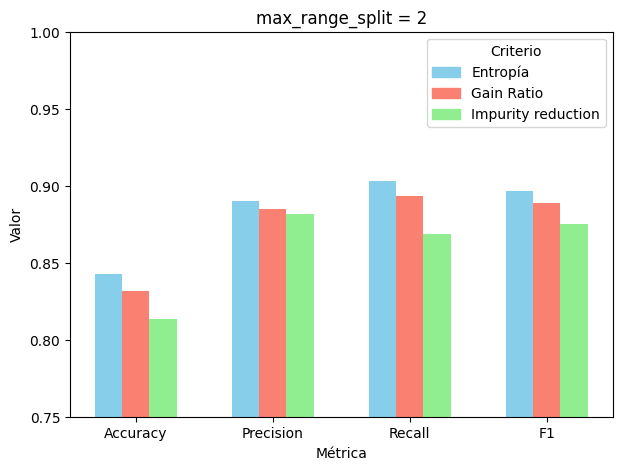

Resultados para max_range_split = 2:
Accuracy:
  Entropia: 0.8424908424908425
  Gain ratio: 0.8315018315018315
  Impurity reduction: 0.8131868131868132

Precision:
  Entropia: 0.8899521531100478
  Gain ratio: 0.8846153846153846
  Impurity reduction: 0.8817733990147784

Recall:
  Entropia: 0.9029126213592233
  Gain ratio: 0.8932038834951457
  Impurity reduction: 0.8689320388349514

F1:
  Entropia: 0.8963855421686747
  Gain ratio: 0.8888888888888888
  Impurity reduction: 0.8753056234718827



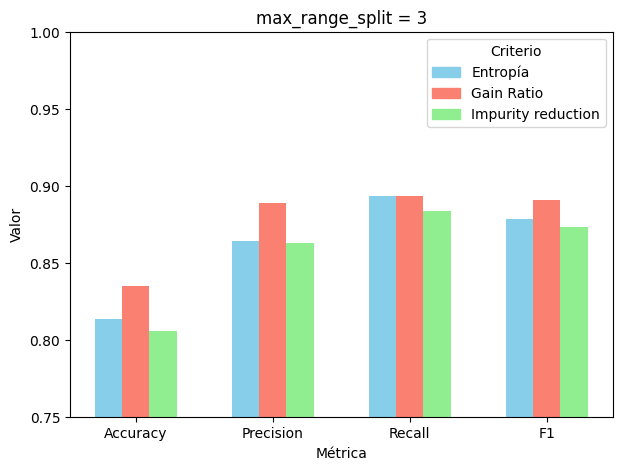

Resultados para max_range_split = 3:
Accuracy:
  Entropia: 0.8131868131868132
  Gain ratio: 0.8351648351648352
  Impurity reduction: 0.8058608058608059

Precision:
  Entropia: 0.863849765258216
  Gain ratio: 0.8888888888888888
  Impurity reduction: 0.8625592417061612

Recall:
  Entropia: 0.8932038834951457
  Gain ratio: 0.8932038834951457
  Impurity reduction: 0.883495145631068

F1:
  Entropia: 0.8782816229116945
  Gain ratio: 0.8910411622276029
  Impurity reduction: 0.8729016786570744



In [9]:
metricas = ['Accuracy', 'Precision', 'Recall', 'F1']

funciones.plot_metrics(resultados_max_range_split_2, 2)

print('Resultados para max_range_split = 2:')
for i, metrica in enumerate(metricas):
    print(f'{metrica}:')
    for key, value in resultados_max_range_split_2.items():
        print(f'  {key}: {value[i]}')
    print("")  

funciones.plot_metrics(resultados_max_range_split_3, 3)

print('Resultados para max_range_split = 3:')
for i, metrica in enumerate(metricas):
    print(f'{metrica}:')
    for key, value in resultados_max_range_split_3.items():
        print(f'  {key}: {value[i]}')
    print("") 

Se observa como la función que utiliza `gain ratio` es superior en todos los casos. Además, también vemos como se obtienen mejores resultados al usar `max_range_split=3`, y en ambos casos hemos conseguido un rendimiento superior a la linea base definda al inicio del documento.

A continuación, repetimos el experimento, pero discretizando el conjunto de datos previo a la ejecución del algoritmo ID3, además de aplicar `one-hot encoding` sobre los atributos `trt` y `strat`. Para esto, el arbol aplica el algoritmo de discretización, y guarda el conjunto de puntos de corte utilizados para cada atributo a discretizar, de forma que pueda luego aplicar los mismos puntos de corte a entradas que no haya visto antes (como pueden ser del conjunto de validación o test).

In [10]:
# Esta celda puede tardar en ejecutarse puesto que se tienen que entrenar 6 modelos

ArbolDecisionMRS2_entropia.entrenar(X_train, Y_train, funciones.get_mejor_atributo_entropia, True, 2, atributos_a_discretizar)

ArbolDecisionMRS2_gain_ratio.entrenar(X_train, Y_train, funciones.get_mejor_atributo_gain_ratio, True, 2, atributos_a_discretizar)

ArbolDecisionMRS2_impurity_reduction.entrenar(X_train, Y_train, funciones.get_mejor_atributo_impurity_reduction, True, 2, atributos_a_discretizar)

ArbolDecisionMRS3_entropia.entrenar(X_train, Y_train, funciones.get_mejor_atributo_entropia, True, 3, atributos_a_discretizar)

ArbolDecisionMRS3_gain_ratio.entrenar(X_train, Y_train, funciones.get_mejor_atributo_gain_ratio, True, 3, atributos_a_discretizar)

ArbolDecisionMRS3_impurity_reduction.entrenar(X_train, Y_train, funciones.get_mejor_atributo_impurity_reduction, True, 3, atributos_a_discretizar)

resultados_max_range_split_2 = funciones.entrenar_y_evaluar([ArbolDecisionMRS2_entropia, ArbolDecisionMRS2_gain_ratio, ArbolDecisionMRS2_impurity_reduction], X_validacion, Y_validacion)
resultados_max_range_split_3 = funciones.entrenar_y_evaluar([ArbolDecisionMRS3_entropia, ArbolDecisionMRS3_gain_ratio, ArbolDecisionMRS3_impurity_reduction], X_validacion, Y_validacion)

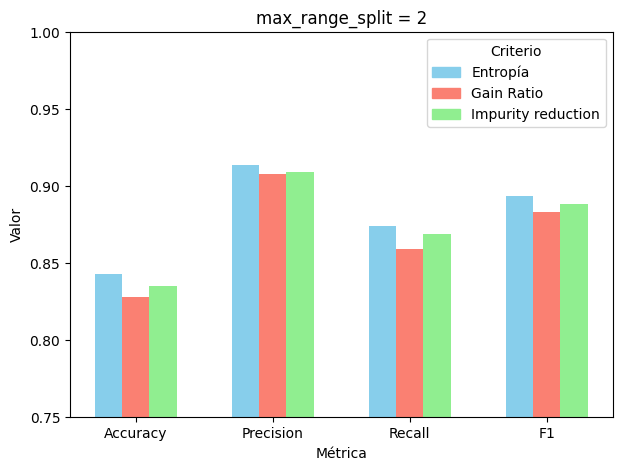

Resultados para max_range_split = 2:
Accuracy:
  Entropia: 0.8424908424908425
  Gain ratio: 0.8278388278388278
  Impurity reduction: 0.8351648351648352

Precision:
  Entropia: 0.9137055837563451
  Gain ratio: 0.9076923076923077
  Impurity reduction: 0.9086294416243654

Recall:
  Entropia: 0.8737864077669902
  Gain ratio: 0.8592233009708737
  Impurity reduction: 0.8689320388349514

F1:
  Entropia: 0.8933002481389578
  Gain ratio: 0.8827930174563591
  Impurity reduction: 0.8883374689826302



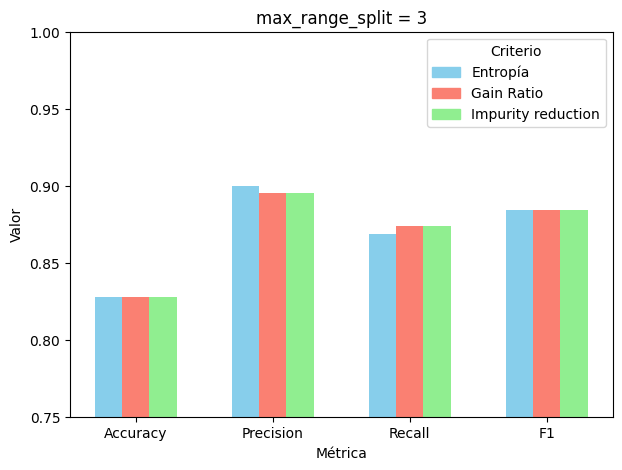

Resultados para max_range_split = 3:
Accuracy:
  Entropia: 0.8278388278388278
  Gain ratio: 0.8278388278388278
  Impurity reduction: 0.8278388278388278

Precision:
  Entropia: 0.8994974874371859
  Gain ratio: 0.8955223880597015
  Impurity reduction: 0.8955223880597015

Recall:
  Entropia: 0.8689320388349514
  Gain ratio: 0.8737864077669902
  Impurity reduction: 0.8737864077669902

F1:
  Entropia: 0.8839506172839506
  Gain ratio: 0.8845208845208845
  Impurity reduction: 0.8845208845208845



In [11]:
metricas = ['Accuracy', 'Precision', 'Recall', 'F1']

funciones.plot_metrics(resultados_max_range_split_2, 2)

print('Resultados para max_range_split = 2:')
for i, metrica in enumerate(metricas):
    print(f'{metrica}:')
    for key, value in resultados_max_range_split_2.items():
        print(f'  {key}: {value[i]}')
    print("")  

funciones.plot_metrics(resultados_max_range_split_3, 3)

print('Resultados para max_range_split = 3:')
for i, metrica in enumerate(metricas):
    print(f'{metrica}:')
    for key, value in resultados_max_range_split_3.items():
        print(f'  {key}: {value[i]}')
    print("") 

Se observa como, al categorizar los datos previo al algoritmo ID3 obtenemos resultados consistentemente mejores en comparación al categorizarlos durante la ejecución.

In [12]:
ArbolDecisionManual = funciones.ArbolDecision()
ArbolDecisionManual.entrenar(X_train_mrs_3, Y_train_mrs_3, funciones.get_mejor_atributo_gain_ratio)
Y_predicho_arbol_decision_manual = ArbolDecisionManual.predecir(X_test_mrs_3)
funciones.plot_confusion_matrix(Y_test_mrs_3, Y_predicho_arbol_decision_manual)	

NameError: name 'X_train_mrs_3' is not defined


- Debe existir alguna instancia donde se compile la información relevante de los experimentos de forma de poder comparar fácilmente los distintos experimentos. Por ejemplo:

_En la tabla 1, se presentan los distintos resultados contra el jugador aleatorio, para los distintos valores de $\alpha$ elegidos. El mejor resultado se obtiene para $\alpha=0.05$, lo que prueba que la estrategia..._

<table>
  <tr>
    <th>$\alpha$</th>
    <th>...</th>
    <th>Turnos</th>
    <th>Error</th>
  </tr>
  <tr>
    <td>0.001</td>
    <td>...</td>
    <td>100</td>
    <td>0.991</td>
  </tr>    
  <tr>
    <td>0.005</td>
    <td>...</td>
    <td>100</td>
    <td>0.987</td>
  </tr>
  <tr style="font-weight:bold">
    <td>0.05</td>
    <td>...</td>
    <td>100</td>
    <td>0.329</td>
  </tr>
  <tr>
    <td>0.5</td>
    <td>...</td>
    <td>100</td>
    <td>0.564</td>
  </tr>    
    <caption>Tabla 1 - Entrenamiento del jugador X para distintos valores de $\alpha$</caption>
</table>


## 4. Comparación

En esta sección se comparará nuestro algoritmo de ID3 contra los algoritmos de la libreria scikit-learn, además del predictor sencillo mencionado al incio del informe:
- DecisionTreeClassifier
- RandomForestClassifier

Para esto, utilizaremos los hiperparametros que hemos encontrado ser los mejores, es decir, la función gain ratio y los atributos a dropear los anteriormente dichos.

In [ ]:
Y_predicho_predictor_simple = [0 for _ in range(len(dataset))]
Y_real = dataset[OBJETIVO]

ArbolDecisionLibreria = DecisionTreeClassifier(criterion='entropy', random_state=12345)
ArbolDecisionLibreria.fit(X_train_librerias, Y_train_librerias)
Y_predicho_arbol_libreria = ArbolDecisionLibreria.predict(X_test_librerias)

RandomForest = RandomForestClassifier(criterion='entropy', random_state=12345)
RandomForest.fit(X_train_librerias, Y_train_librerias)
Y_predicho_random_forest = RandomForest.predict(X_test_librerias)

accuracy_manual, f1_manual = resultados_max_range_split_3['Gain ratio'][0], resultados_max_range_split_3['Gain ratio'][3]
accuracy_arbol_libreria, _, _, f1_arbol_libreria = funciones.get_accuracy_precision_recall_f1(Y_test_librerias, Y_predicho_arbol_libreria)
accuracy_random_forest, _, _, f1_random_forest = funciones.get_accuracy_precision_recall_f1(Y_test_librerias, Y_predicho_random_forest)
accuracy_predictor_simple, _, _, f1_predictor_simple = funciones.get_accuracy_precision_recall_f1(Y_real, Y_predicho_predictor_simple)


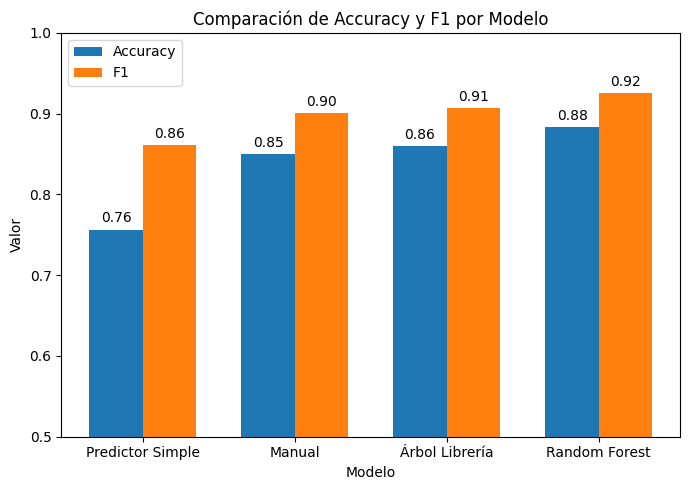

In [ ]:
funciones.plot_accuracies_and_f1s([accuracy_predictor_simple, accuracy_manual, accuracy_arbol_libreria, accuracy_random_forest],
                                  [f1_predictor_simple, f1_manual, f1_arbol_libreria, f1_random_forest])

# Aca podemos tirar sobre el intervalo de confianza del predictor 

## 5. Conclusión

Una breve conclusión del trabajo realizado. Por ejemplo: 
- ¿cuándo se dieron los mejores resultados del jugador?
- ¿encuentra alguna relación con los parámetros / oponentes/ atributos elegidos?
- ¿cómo mejoraría los resultados?

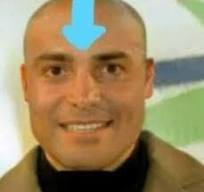